In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from auxiliar_func import *
from plot_func import *

In [78]:
target = 'income_50k'
df_tr = pd.read_csv('../train.csv')
df_tr = df_tr[:1000]

prep_par, model_par = get_best_params('./results/results_rf.csv')
prep_par['generate_dummies'] = False
rf = RandomForestClassifier(**model_par)
df_tr_pre = preprocessing(df_tr, **prep_par)

df_tr_pre = pd.get_dummies(df_tr_pre, prefix_sep='$')

#  summarize column names
df_tr_pre.columns = [x.split('(')[0] for x in df_tr_pre.columns]
df_tr_pre.columns = [x.replace('admin and managerial', '') for x in df_tr_pre.columns]

In [79]:
rf.fit(df_tr_pre.drop(target, axis=1), df_tr_pre[target])

RandomForestClassifier(max_depth=30, n_estimators=125, random_state=42)

Index(['age', 'wage_per_hour', 'capital_gains', 'capital_losses',
       'stock_dividends', 'num_emp', 'weeks_worked',
       'class_worker$ Federal government', 'class_worker$ Local government',
       'class_worker$ Never worked',
       ...
       'own_or_self$1', 'own_or_self$2', 'vet_question$ No',
       'vet_question$ Not in universe', 'vet_question$ Yes', 'vet_benefits$0',
       'vet_benefits$1', 'vet_benefits$2', 'year$94', 'year$95'],
      dtype='object', length=391)


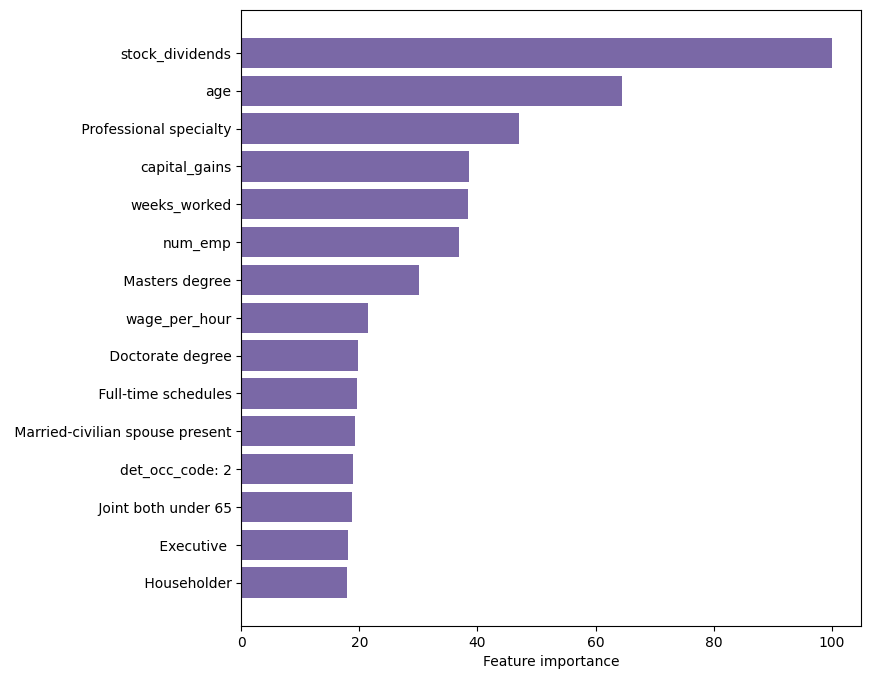

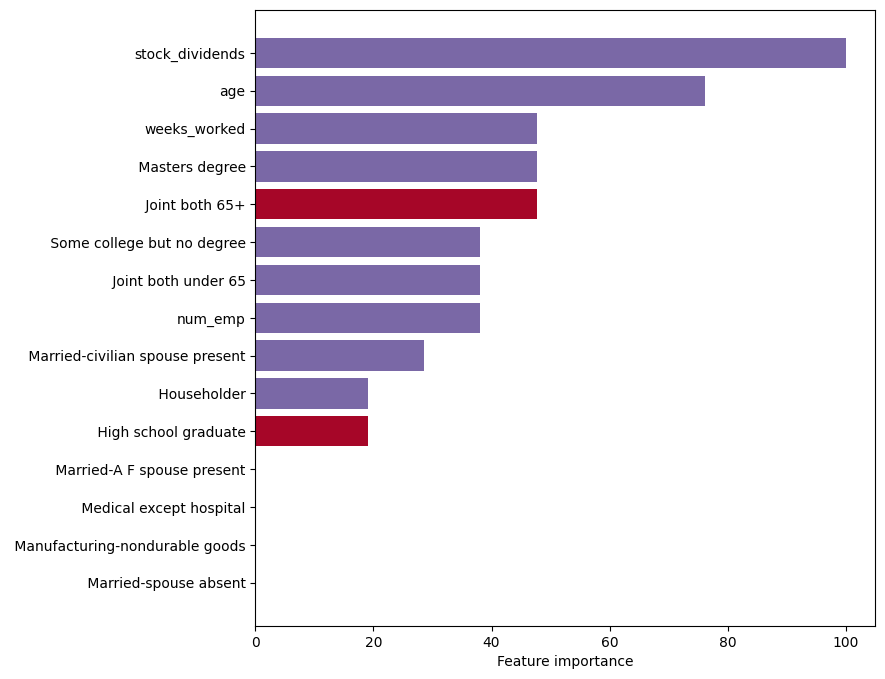

In [80]:
def plot_feature_importance_gini(model, X, y, n_features=20, save=''):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_names = [x.split('$')[-1] if len(x) > 20 else x.replace('$', ': ') for x in X.columns]
    sorted_idx = np.argsort(feature_importance)

    # get the correlation with the target
    corr = X.corrwith(y)
    corr = corr[sorted_idx[-n_features:]]
    corr = corr / corr.max()

    plt.figure(figsize=(8, 8))
    for i in range(n_features):
        color = '#7A68A6' if corr[i] > 0 else '#A60628'
        plt.barh(i, feature_importance[sorted_idx[-n_features:]][i], align='center', color=color)
    
    plt.yticks(np.arange(n_features), [feature_names[i] for i in sorted_idx[-n_features:]])
    plt.xlabel('Feature importance')
    if save:
        plt.savefig(save, bbox_inches='tight')
    plt.show()

def plot_feature_importance_perm(model, X, y, n_features=20, save=''):
    from sklearn.inspection import permutation_importance
    feature_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    feature_importance.importances_mean = 100.0 * (feature_importance.importances_mean / feature_importance.importances_mean.max())
    feature_names = [x.split('$')[-1] if len(x) > 20 else x.replace('$', ': ') for x in X.columns]
    sorted_idx = np.argsort(feature_importance.importances_mean)

    corr = X.corrwith(y)
    corr = corr[sorted_idx[-n_features:]]
    corr = corr / corr.max()

    plt.figure(figsize=(8, 8))
    for i in range(n_features):
        color = '#7A68A6' if corr[i] > 0 else '#A60628'
        plt.barh(i, feature_importance.importances_mean[sorted_idx[-n_features:]][i], align='center', color=color)
    
    plt.yticks(np.arange(n_features), [feature_names[i] for i in sorted_idx[-n_features:]])
    plt.xlabel('Feature importance')
    if save:
        plt.savefig(save, bbox_inches='tight')
    plt.show()

plot_feature_importance_gini(rf, df_tr_pre.drop(target, axis=1), df_tr_pre[target], 15, save='figures/feat_imp/feature_importance_gini.pdf')
plot_feature_importance_perm(rf, df_tr_pre.drop(target, axis=1), df_tr_pre[target], 15, save='figures/feat_imp/feature_importance_perm.pdf')